In [52]:
import numpy as np
import pandas as pd
import os

#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.5.0


[]

In [53]:
import contextlib
import functools
import time

@contextlib.contextmanager
def timed_execution():
  t0 = time.time()
  yield
  dt = time.time() - t0
  print('Evaluation took: %f seconds' % dt)

def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

def np_value(tensor):
  """Get numpy value out of possibly nested tuple of tensors."""
  if isinstance(tensor, tuple):
    return type(tensor)(*(np_value(t) for t in tensor))
  else:
    return tensor.numpy()

def run(optimizer):
  """Run an optimizer and measure it's evaluation time."""
  optimizer()  # Warmup.
  with timed_execution():
    result = optimizer()
  return np_value(result)

In [54]:
data = pd.read_csv("./data/data6a.csv")
data.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [55]:
data.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


In [56]:
print(len(data[data.f == "C"]))
print(len(data[data.f == "T"]))

50
50


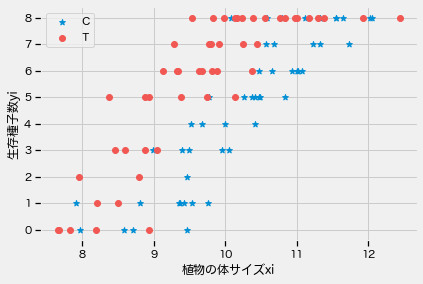

In [57]:

plt.scatter(data[data.f == "C"].x, data[data.f == "C"].y, marker="*", label="C")
plt.scatter(data[data.f == "T"].x, data[data.f == "T"].y, marker="o", c=TFColor[0], label="T")
plt.legend()
plt.xlabel("植物の体サイズxi")
plt.ylabel("生存種子数yi")
plt.show()

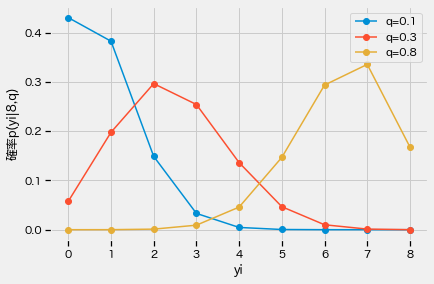

In [58]:
N = 8
probs = [0.1, 0.3, 0.8]
rvs = np.arange(N+1)
dist = tfd.Binomial(total_count=N, probs=probs[0])
y1 = dist.prob(rvs)
dist = tfd.Binomial(total_count=N, probs=probs[1])
y2 = dist.prob(rvs)
dist = tfd.Binomial(total_count=N, probs=probs[2])
y3 = dist.prob(rvs)

plt.plot(rvs, y1, marker="o", label="q=%.1f" %(probs[0]))
plt.plot(rvs, y2, marker="o", label="q=%.1f" %(probs[1]))
plt.plot(rvs, y3, marker="o", label="q=%.1f" %(probs[2]))
plt.xlabel("yi")
plt.ylabel("確率p(yi|8,q)")
plt.legend()
plt.show()

In [59]:
def logistic(z):
    return 1. / (1. + tf.exp(-z))

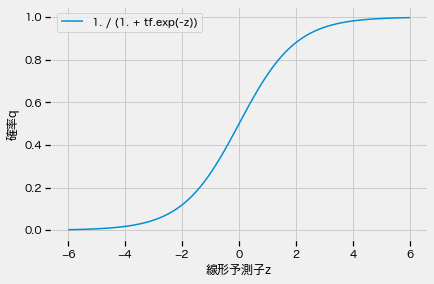

In [60]:
zz = np.linspace(-6., 6., 100)
qq = logistic(zz)

plt.plot(zz, qq, label="1. / (1. + tf.exp(-z))")
plt.xlabel("線形予測子z")
plt.ylabel("確率q")
plt.legend()
plt.show()

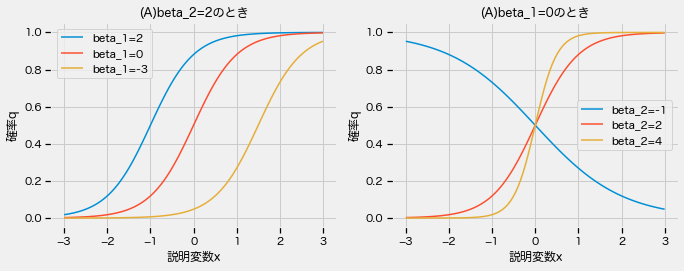

In [61]:
def linear_predictor(beta_1, beta_2, x):
    return beta_1 + beta_2 * x

xx = np.linspace(-3, 3, 100)

beta_2 = 2
beta_1s = [2, 0, -3]
beta_2_q = np.stack((
    logistic(linear_predictor(beta_1s[0], beta_2, xx)),
    logistic(linear_predictor(beta_1s[1], beta_2, xx)),
    logistic(linear_predictor(beta_1s[2], beta_2, xx))
))

beta_1 = 0
beta_2s = [-1, 2, 4]
beta_1_q = np.stack((
    logistic(linear_predictor(beta_1, beta_2s[0], xx)),
    logistic(linear_predictor(beta_1, beta_2s[1], xx)),
    logistic(linear_predictor(beta_1, beta_2s[2], xx)),
))

def plot(idx, x, y, param, ax):
    for i, d in enumerate(y):
        ax.plot(x, d, label="beta_%i=%i" %(idx, param[i]))
        ax.set_xlabel("説明変数x")
        ax.set_ylabel("確率q")
        ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
axes[0].set_title("(A)beta_2=2のとき")
plot(1, xx, beta_2_q, beta_1s, axes[0])
axes[1].set_title("(A)beta_1=0のとき")
plot(2, xx, beta_1_q, beta_2s, axes[1])
plt.show()

# ロジスティック回帰

In [62]:
data = pd.read_csv("./data/data6a.csv")
data.f.replace("C", 0, inplace=True)
data.f.replace("T", 1, inplace=True)
data.astype({"f": "int64"})

xx = data[data.f == 0].x
yy = data[data.f == 0].y
ff = data[data.f == 0].f
N = 8

def linear_predictor(beta_1, beta_2, x, beta_3, f):
    return beta_1 + beta_2 * x + beta_3 * f

In [63]:
@make_val_and_grad_fn
def logl(beta):
    q = logistic(linear_predictor(beta[0], beta[1], xx, beta[2], ff))
    dist = tfd.Binomial(total_count=N, probs=q)
    logl = -tf.reduce_sum(dist.log_prob(yy))
    return logl

dim = 3

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results_f_c = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results_f_c.converged)
print('Location of the minimum:', results_f_c.position) 
print('Number of iterations:', results_f_c.num_iterations)

Evaluation took: 0.020726 seconds
L-BFGS Results
From: [ 0.54762935 -0.33662401 -0.3503531 ]
Converged: True
Location of the minimum: [-18.523327    1.8525095  -0.3503531]
Number of iterations: 11


In [64]:
linxx = np.linspace(np.min(xx), np.max(xx), 100)
q = logistic(linear_predictor(results_f_c.position[0], results_f_c.position[1], linxx, results_f_c.position[2], 0))
yhat_c = tfd.Binomial(total_count=N, probs=q).mean()

In [65]:
sample_x = np.array([8.5, 10., 12.])
sample_q = logistic(linear_predictor(results_f_c.position[0], results_f_c.position[1], sample_x, results_f_c.position[2], 0.))
dist = tfd.Binomial(total_count=N, probs=sample_q)
samples_c = dist.sample(100)
samples_c = np.add(samples_c, np.random.uniform(-0.5, 0.5, size=(100, 3)))

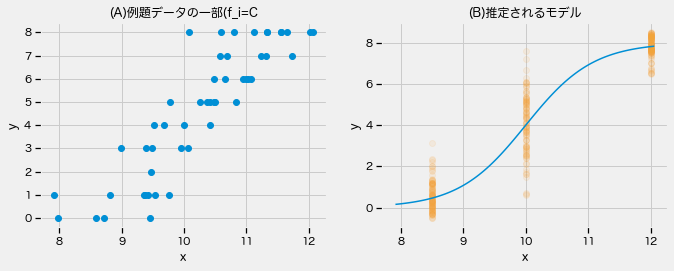

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
ax = axes[0]
ax.set_title("(A)例題データの一部(f_i=C")
ax.scatter(xx, yy)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax = axes[1]
ax.set_title("(B)推定されるモデル")
for sample in samples_c:
    ax.scatter(sample_x, sample, c=TFColor[1], alpha=0.1, marker="o")
ax.plot(linxx, yhat_c)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [45]:
xx = data[data.f == 1].x
yy = data[data.f == 1].y
ff = data[data.f == 1].f

@make_val_and_grad_fn
def logl(beta):
    q = logistic(linear_predictor(beta[0], beta[1], xx, beta[2], ff))
    dist = tfd.Binomial(total_count=N, probs=q)
    logl = -tf.reduce_sum(dist.log_prob(yy))
    return logl

dim = 3

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results_f_t = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results_f_t.converged)
print('Location of the minimum:', results_f_t.position) 
print('Number of iterations:', results_f_t.num_iterations)

Evaluation took: 0.018250 seconds
L-BFGS Results
From: [-0.02811024  0.17799331 -1.02305846]
Converged: True
Location of the minimum: [-8.796053   2.0688453 -9.791021 ]
Number of iterations: 8


In [49]:
q = logistic(linear_predictor(results_f_t.position[0], results_f_t.position[1], linxx, results_f_t.position[2], 1))
dist = tfd.Binomial(total_count=N, probs=q)
yhat_t = dist.sample(10000)
yhat_t = tf.reduce_mean(yhat_t, axis=0)

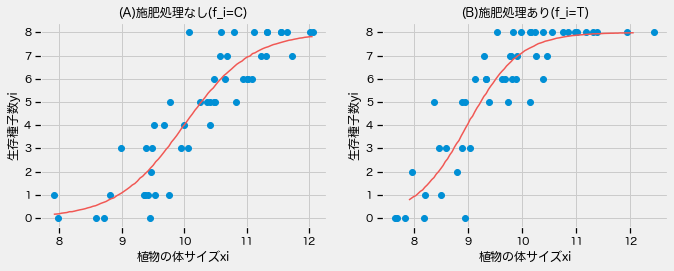

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
ax = axes[0]
ax.set_title("(A)施肥処理なし(f_i=C)")
ax.scatter(data[data.f == 0].x, data[data.f == 0].y)
ax.plot(linxx, yhat_c, color=TFColor[0])
ax.set_xlabel("植物の体サイズxi")
ax.set_ylabel("生存種子数yi")
ax = axes[1]
ax.set_title("(B)施肥処理あり(f_i=T)")
ax.scatter(data[data.f == 1].x, data[data.f == 1].y)
ax.plot(linxx, yhat_t, color=TFColor[0])
ax.set_xlabel("植物の体サイズxi")
ax.set_ylabel("生存種子数yi")
plt.show()